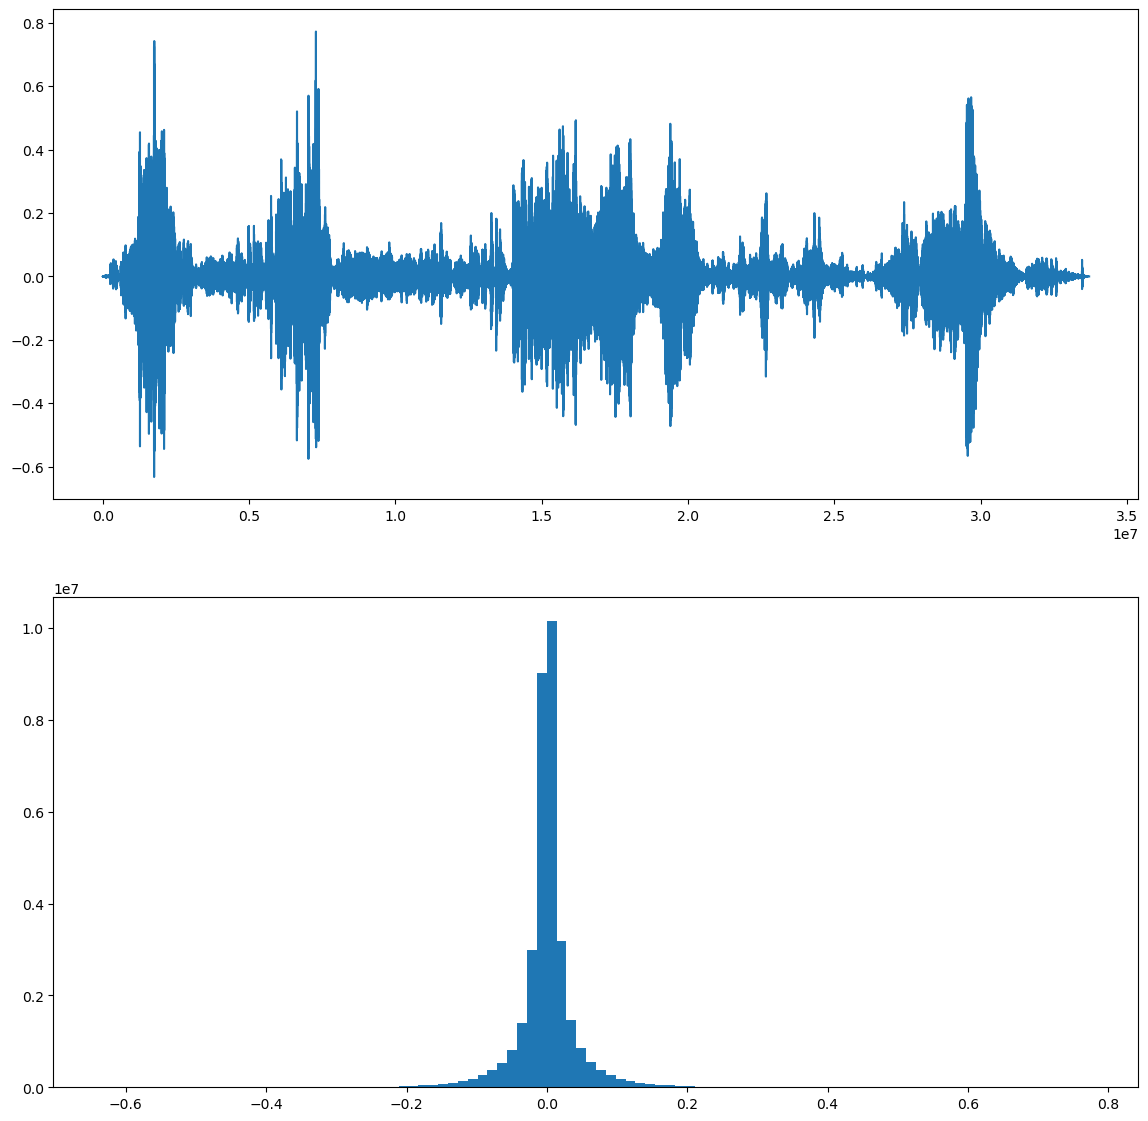

In [3]:
import numpy as np
import matplotlib.pyplot as plt
amp_data = np.load('amp_data.npz')['amp_data']
fig,ax= plt.subplots(2,1,figsize=(14,14))
x_axis = range(amp_data.shape[0])
ax[0].plot(x_axis,amp_data)
ax[1].hist(amp_data,bins = 100)
plt.show()


In [2]:
amp_data.shape

(33713280,)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
def train_val_test_split(input, train_portion, val_portion, test_portion):
    shuff_idx = np.random.permutation(input.shape[0])
    size = shuff_idx.shape[0]
    train_idx = shuff_idx[:int(train_portion*size)]
    val_indx = shuff_idx[int(train_portion*size):-int(test_portion*size)]
    test_idx = shuff_idx[-int(test_portion*size):]
    train,val,test = input[train_idx,:],input[val_indx,:],input[test_idx,:]
    return train,val,test
trimmed_data = amp_data[:-(amp_data.shape[0]%21)]
trimmed_data = np.reshape(trimmed_data,(-1,21))
shuf_train,shuf_val,shuf_test = train_val_test_split(trimmed_data,0.7,0.15,0.15)
X_shuf_train,y_shuf_train = shuf_train[:,:20],shuf_train[:,20].flatten()
X_shuf_val,y_shuf_val = shuf_val[:,:20],shuf_val[:,20].flatten()
X_shuf_test,y_shuf_test = shuf_test[:,:20],shuf_test[:,20].flatten()


In [5]:
shuf_train.shape[0] + shuf_val.shape[0] + shuf_test.shape[0]
# trimmed_data.shape[0]

1605394

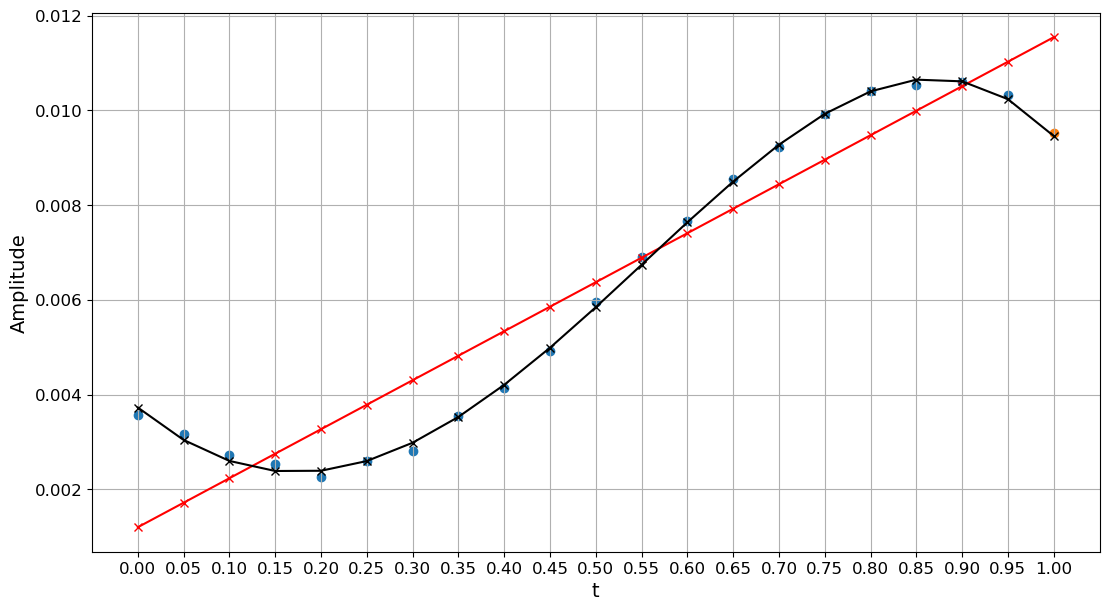

0.011543032997532897 0.009458681624248164


In [24]:
import numpy as np
import matplotlib.pyplot as plt
time_axis = np.array([i/20 for i in range(20)])
predict_axis = np.append(time_axis,1)
plt.figure(figsize=(13,7))
plt.xticks(predict_axis,fontsize = 12)
plt.xlabel('t',fontsize = 14)
plt.ylabel('Amplitude',fontsize = 14)
plt.yticks(fontsize = 12)
def transform(array):
    return np.array([[1,t,t**2,t**3,t**4] for t in array])
def scatter_for_row(row): 
    plt.scatter(time_axis,row)
    plt.grid()
    

def plot_straight(row):
    biased_time = np.array([[1,t] for t in predict_axis])
    X = biased_time[:-1]
    y = biased_time[-1]
    w_straight = np.linalg.lstsq(X, row, rcond=None)[0]
    plt.plot(predict_axis,np.dot(biased_time, w_straight), '-rx')
    return np.dot(y, w_straight)

def plot_transform(row):
    trf_time_axis = transform(predict_axis)
    phi_X = trf_time_axis[:-1]
    y = trf_time_axis[-1]
    w_tr = np.linalg.lstsq(phi_X,row,rcond=None)[0]
    plt.plot(predict_axis, np.dot(trf_time_axis,w_tr), '-kx')
    return np.dot(y,w_tr)

n = 56
snip = X_shuf_train[n]  
scatter_for_row(snip)
plt.scatter(1,y_shuf_train[n])
y_predict_straight = plot_straight(snip)
y_predict_curve = plot_transform(snip)
plt.show()
print(y_predict_straight, y_predict_curve)

In [26]:
def Phi(C,K):
    return np.array([[((20-C+t)/20)**k for k in range(K)] for t in range(C)])

Phi(20, 2)


array([[1.  , 0.  ],
       [1.  , 0.05],
       [1.  , 0.1 ],
       [1.  , 0.15],
       [1.  , 0.2 ],
       [1.  , 0.25],
       [1.  , 0.3 ],
       [1.  , 0.35],
       [1.  , 0.4 ],
       [1.  , 0.45],
       [1.  , 0.5 ],
       [1.  , 0.55],
       [1.  , 0.6 ],
       [1.  , 0.65],
       [1.  , 0.7 ],
       [1.  , 0.75],
       [1.  , 0.8 ],
       [1.  , 0.85],
       [1.  , 0.9 ],
       [1.  , 0.95]])

In [44]:
def make_vv(C,K):
    phi_t1 = np.array([1 for k in range(K)])
    phi = Phi(C,K)
    pseudo_inv = np.linalg.inv((phi.T.dot(phi)))
    return np.dot(phi, pseudo_inv.T).dot(phi_t1)

In [45]:
v = make_vv(20,7)
a = np.dot(v.T, X_shuf_train[7])
phi_t1 = np.array([1**k for k in range(7)])
phi = Phi(20,7)
pseudo_inv = np.linalg.inv((phi.T.dot(phi)))
w = np.dot(pseudo_inv.dot(phi.T),X_shuf_train[7])
b = w.T.dot(phi_t1)
np.isclose(a,b)
# a,b

True

In [46]:
straight = make_vv(20,2)
y_straight = straight.T.dot(X_shuf_train[n])
transf = make_vv(20,5)
y_transform = transf.T.dot(X_shuf_train[n])
np.allclose([y_straight,y_transform],[y_predict_straight,y_predict_curve])

True

In [11]:
minimum = np.Infinity
bestC,bestK = np.Infinity, np.Infinity
for K in range(2, 21):
    for C in range(K,21):
        sum = 0
        v = make_vv(C,K)
        for n in range(X_shuf_train.shape[0]):            
            sqr_err = np.square(v.T.dot(X_shuf_train[n,-C:]) - y_shuf_train[n])
            sum += sqr_err
        print('C:{0}, K{1}, square error:{2}'.format(C,K,sum))
        if (sum < minimum):
            minimum = sum
            bestC = C
            bestK = K
        

C:2, K2, square error:15.26478499919475
C:3, K2, square error:27.87789914457344
C:4, K2, square error:44.08229633839813
C:5, K2, square error:65.11616622650278
C:6, K2, square error:90.42230689318676
C:7, K2, square error:119.8553837202904
C:8, K2, square error:152.9339716460366
C:9, K2, square error:188.66304290807784
C:10, K2, square error:225.813252172338
C:11, K2, square error:263.2998013635749
C:12, K2, square error:300.45384426764804
C:13, K2, square error:336.7169637936244
C:14, K2, square error:371.7566294741227
C:15, K2, square error:405.5240385776095
C:16, K2, square error:438.06142512954693
C:17, K2, square error:469.54270513336127
C:18, K2, square error:500.1266215389802
C:19, K2, square error:529.8663012058921
C:20, K2, square error:558.7996804770295
C:3, K3, square error:21.712186006903654
C:4, K3, square error:29.095130288093316
C:5, K3, square error:36.636150696352075
C:6, K3, square error:47.20047352767126
C:7, K3, square error:59.50175765682292
C:8, K3, square error:7

In [12]:
bestC, bestK, minimum


(2, 2, 15.26478499919475)

In [47]:
v = make_vv(2,2)
mean_train_err = 0
for n in range(X_shuf_train.shape[0]):
    sqr_err = np.square(v.T.dot(X_shuf_train[n,-2:]) - y_shuf_train[n])
    mean_train_err += sqr_err
    
mean_train_err = mean_train_err/X_shuf_train.shape[0]

mean_val_err = 0
for n in range(X_shuf_val.shape[0]):
    sqr_err = np.square(v.T.dot(X_shuf_val[n,-2:]) - y_shuf_val[n])
    mean_val_err += sqr_err
    
mean_val_err = mean_val_err/X_shuf_val.shape[0]

mean_test_err = 0
for n in range(X_shuf_test.shape[0]):
    sqr_err = np.square(v.T.dot(X_shuf_test[n,-2:]) - y_shuf_test[n])
    mean_test_err += sqr_err
    
mean_test_err = mean_test_err/X_shuf_test.shape[0]
mean_train_err, mean_val_err, mean_test_err

(1.3741638418344483e-05, 1.2782777213163067e-05, 1.3278531960132793e-05)

In [42]:
for c in range(1,21):
    v = np.linalg.lstsq(X_shuf_train[:,-c:],y_shuf_train,rcond=None)[0]
    error = y_shuf_train - np.dot(X_shuf_train[:,-c:],v)
    val_error = y_shuf_val - np.dot(X_shuf_val[:,-c:],v)
    mean_train_error = (1/X_shuf_train.shape[0])*error.T.dot(error)
    mean_val_error = (1/X_shuf_val.shape[0])*val_error.T.dot(val_error)
    print("C:{0}, Mean train error is: {1}, validation error is: {2}".format(c, mean_train_error,mean_val_error))


C:1, Mean train error is: 3.6784003690632834e-05, validation error is: 3.641723002165762e-05
C:2, Mean train error is: 1.1795154393436619e-05, validation error is: 1.1052361098353735e-05
C:3, Mean train error is: 1.0064469450877864e-05, validation error is: 9.342312278050957e-06
C:4, Mean train error is: 9.680235434908348e-06, validation error is: 9.107634982980302e-06
C:5, Mean train error is: 9.223428969751984e-06, validation error is: 8.715486638547671e-06
C:6, Mean train error is: 9.020835403407851e-06, validation error is: 8.569819811488012e-06
C:7, Mean train error is: 8.468319382538995e-06, validation error is: 8.175951628315036e-06
C:8, Mean train error is: 8.208555391457555e-06, validation error is: 8.052470229011714e-06
C:9, Mean train error is: 8.13505464589795e-06, validation error is: 8.011366544850423e-06
C:10, Mean train error is: 8.036161446482762e-06, validation error is: 7.860868810219313e-06
C:11, Mean train error is: 7.974044842354048e-06, validation error is: 7.776

In [48]:
v = np.linalg.lstsq(X_shuf_train[:,-15:],y_shuf_train,rcond=None)[0]
test_error = y_shuf_test-np.dot(X_shuf_test[:,-15:],v)
mean_test_error = (1/X_shuf_test.shape[0])*test_error.T.dot(test_error)
print(mean_test_err, mean_test_error)

1.3278531960132793e-05 7.521151390659186e-06


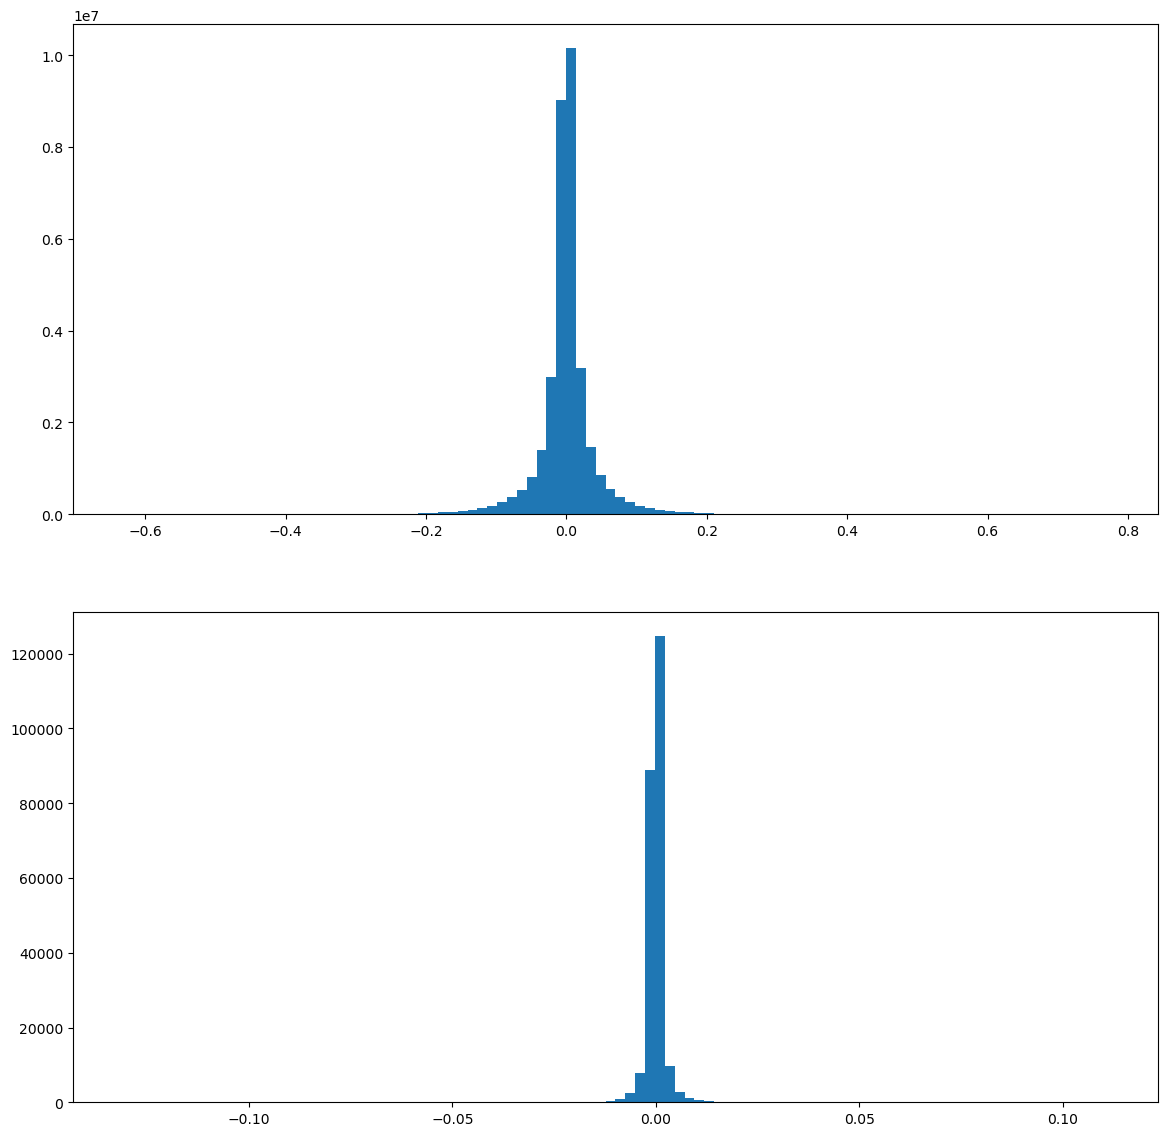

array([ 0.04356636, -0.13106934,  0.24194971, -0.39914679,  0.58095054,
       -0.77626334,  0.96668841, -1.18416942,  1.52230104, -1.80167694,
        1.91153795, -1.96357914,  2.08416598, -2.49899328,  2.39328284])

In [60]:
v = np.linalg.lstsq(X_shuf_train[:,-15:],y_shuf_train,rcond=None)[0]
val_error = y_shuf_val - np.dot(X_shuf_val[:,-15:],v)
fig,ax= plt.subplots(2,1,figsize=(14,14))
x_axis = range(amp_data.shape[0])
ax[0].hist(amp_data,bins = 100)
ax[1].hist(val_error,bins=100)
plt.show()
val_error.max(),val_error.min(), amp_data.max(), amp_data.min()
v